## Running hyperparameter optimization - Part 2

This notebook goes through part two of the steps and codes for identifying the optimal hyperparameter settings for the Variational Autoencoder framework for integrating multi-omics and clinical data spanning both categorical and continuous variables. <br>

The optimal settings are identified based on multiple steps cosidering both reconstruction on the test and training sets as well as the stability/similiarity of the latent space in case of repeated training. Part one focus on the test and training reconstruction accuracies using in <i>MOVE_hyperparameter_optimization_reconstruction.ipynb</i>. From those results the optimal combination are then tested for stability of the latent space in repeated training using this notebook.

Importing the packages

In [1]:
from hydra import initialize, compose
from omegaconf import OmegaConf

from move.training.train import optimize_stability
from move.utils.data_utils import get_data, get_list_value, merge_configs
from move.utils.visualization_utils import draw_boxplot
from move.utils.analysis import get_top10_stability, calculate_latent, make_and_save_best_stability_params

The notebook reads a default config and then overrides with user-defined configs in data.yaml, model.yaml and tuning_stability.yaml files. Finally, it reads the needed variables. 

The next part is for reading in the data. This example uses the different datatypes included in the publication of MOVE which consist of three categorical datatypes and seven continuous. Since the patients data is not available for testing, the notebook uses a random data generated with make_random_data.py file.

In [3]:
#Getting the data
cat_list, con_list, cat_names, con_names, headers_all, drug, drug_h = get_data(raw_data_path, interim_data_path, categorical_names, continuous_names, data_of_interest)    

For this part we use all the data contraty to part 1 where it was divided into trainig and test, and investigate how similar the latent space is between the repeated runs. Below we define the selected hyper-parameter settings with equal or close to equal performance based on part 1. For plotting purposes we only test on three different "types" here being size of the hidden layer (nHidden), size of the latent space (nLatents) and the drop-out (drop_outs). The number of hidden lasyers are set to 1 (nl=1). We here repeat the traininng 5 times.
We run the full grid search. Here we also save the UMAP embeddings for the posibility of a visual investigation of the results.

In [4]:
#Performing hyperparameter tuning
embeddings, latents, con_recons, cat_recons, recon_acc = optimize_stability(nHiddens, nLatents, 
                                                                            nDropout, nBeta, repeat,
                                                                            nepochs, nLayers,
                                                                            batch_sizes, lrate, 
                                                                            kld_steps, batch_steps, 
                                                                            cuda, processed_data_path, 
                                                                            con_list, cat_list,
                                                                            continuous_weights, categorical_weights,
                                                                            seed)

Beginning the hyperparameter tuning for stability.

[500]+20, do: 0.1, b: 1e-05
	Epoch: 1	Loss: 13.793188	CE: 3.6679399	SSE: 10.125248	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 12.963851	CE: 3.5945633	SSE: 9.369288	KLD: 0.0000	Batchsize: 10
	Epoch: 3	Loss: 12.563400	CE: 3.5487225	SSE: 9.014678	KLD: 0.0000	Batchsize: 10
	Epoch: 4	Loss: 12.339892	CE: 3.5130972	SSE: 8.826794	KLD: 0.0000	Batchsize: 10
====> Test set loss: 11.9372
[500]+20, do: 0.1, b: 1e-05
	Epoch: 1	Loss: 13.789869	CE: 3.6788987	SSE: 10.110970	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 12.966288	CE: 3.5967237	SSE: 9.369564	KLD: 0.0000	Batchsize: 10
	Epoch: 3	Loss: 12.572732	CE: 3.5477292	SSE: 9.025003	KLD: 0.0000	Batchsize: 10
	Epoch: 4	Loss: 12.359632	CE: 3.5147386	SSE: 8.844893	KLD: 0.0000	Batchsize: 10
====> Test set loss: 12.1037
[500]+20, do: 0.1, b: 1e-05
	Epoch: 1	Loss: 13.794003	CE: 3.6716135	SSE: 10.122389	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 12.970177	CE: 3.5957514	SSE: 9.374426	KLD: 0.0000	Batchsize: 10
	Ep

Below is calcualtion and visualisation only focusing on the top 10 closest neigbour for each individual. \
The next part compared based on all of the latent space. Furthermore, it includes code for calculation on cluster stability if the latent space is to be used for clustering (not used by MOVE in the paper here only cosine similarity on latent is included).

In [5]:
# Getting stability results 
stability_top10, stability_top10_df = get_top10_stability(nHiddens, nLatents, nDropout, nLayers, repeat, latents, batch_sizes, nBeta)

stability_total, rand_index, stability_total_df = calculate_latent(nHiddens, nLatents, nDropout, repeat, nLayers, nBeta, latents, batch_sizes)
    

[500]+20, do: 0.1, b: 1e-05
0
1
2
3
4


The next part plots the figures for visual evaluation of the performances. \
The except block is added to help handle the error in case the selected set of hyperparameter values is not suited for the visualization.

Visualizing the hyperparameter tuning results



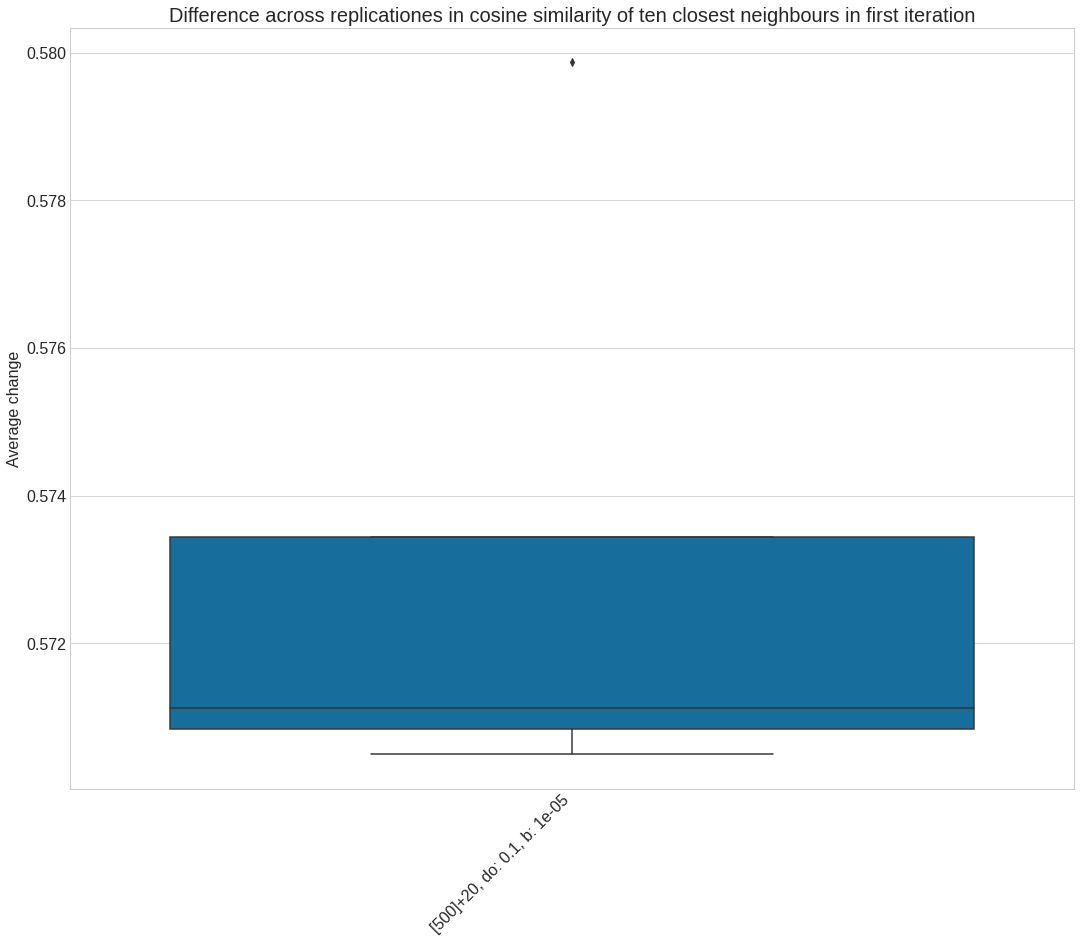

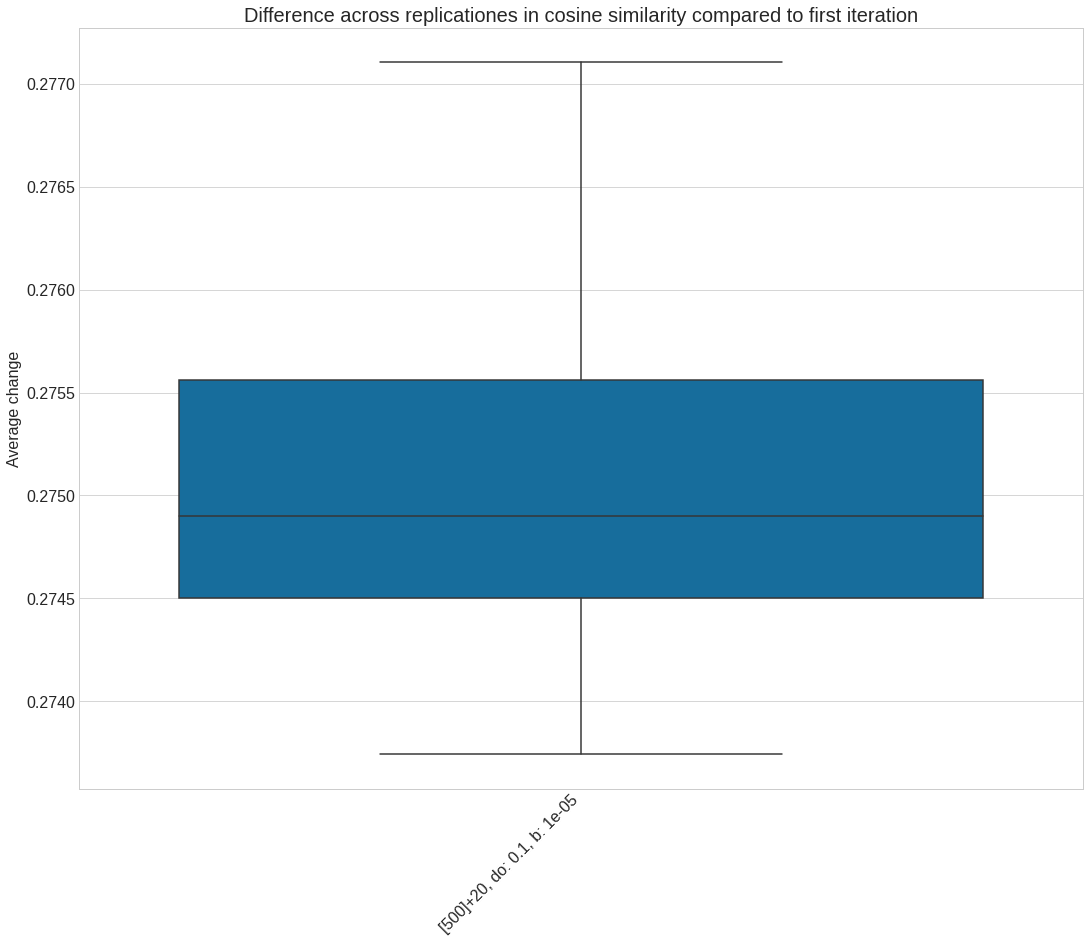

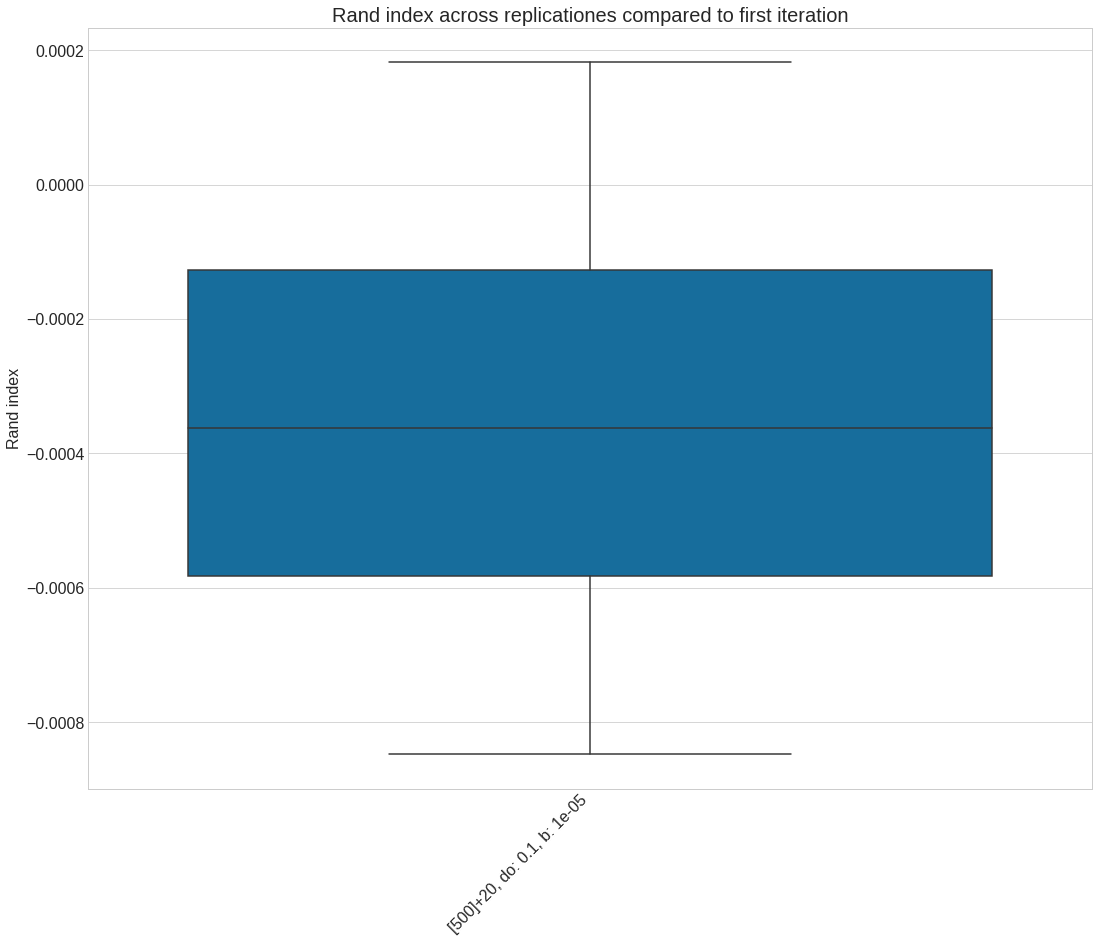

In [6]:
# Plotting the results 
try: 
    draw_boxplot(path=processed_data_path,
                 df=stability_top10,
                 title_text='Difference across replicationes in cosine similarity of ten closest neighbours in first iteration',
                 y_label_text="Average change",
                 save_fig_name="stability_top10")

    draw_boxplot(path=processed_data_path,
                 df=stability_total,
                 title_text='Difference across replicationes in cosine similarity compared to first iteration',
                 y_label_text="Average change",
                 save_fig_name="stability_all")

    draw_boxplot(path=processed_data_path,
                 df=rand_index,
                 title_text='Rand index across replicationes compared to first iteration',
                 y_label_text="Rand index",
                 save_fig_name="rand_index_all")
    print('Visualizing the hyperparameter tuning results\n')

except:
    print('Could not visualize the results\n')

We select the best hyperparameter set as the highest cosine similarity on the latent space.

In [7]:
# Getting best set of hyperparameters
hyperparams_names = ['num_hidden', 'num_latent', 'num_layers', 'dropout', 'beta', 'batch_sizes']
make_and_save_best_stability_params(stability_total_df, hyperparams_names, nepochs)

Starting calculating the best hyperparameter values used in further model trainings
Saving best hyperparameter values in training_latent.yaml: 
 num_hidden: 500
num_latent: 20
num_layers: 1
dropout: 0.1
beta: 1.0e-05
batch_sizes: 10
tuned_num_epochs: 4

Saving best hyperparameter values in training_association.yaml: 
num_hidden: 500
num_latent:
- 20
- 20
- 20
num_layers: 1
dropout: 0.1
beta: 1.0e-05
batch_sizes: 10
tuned_num_epochs: 4



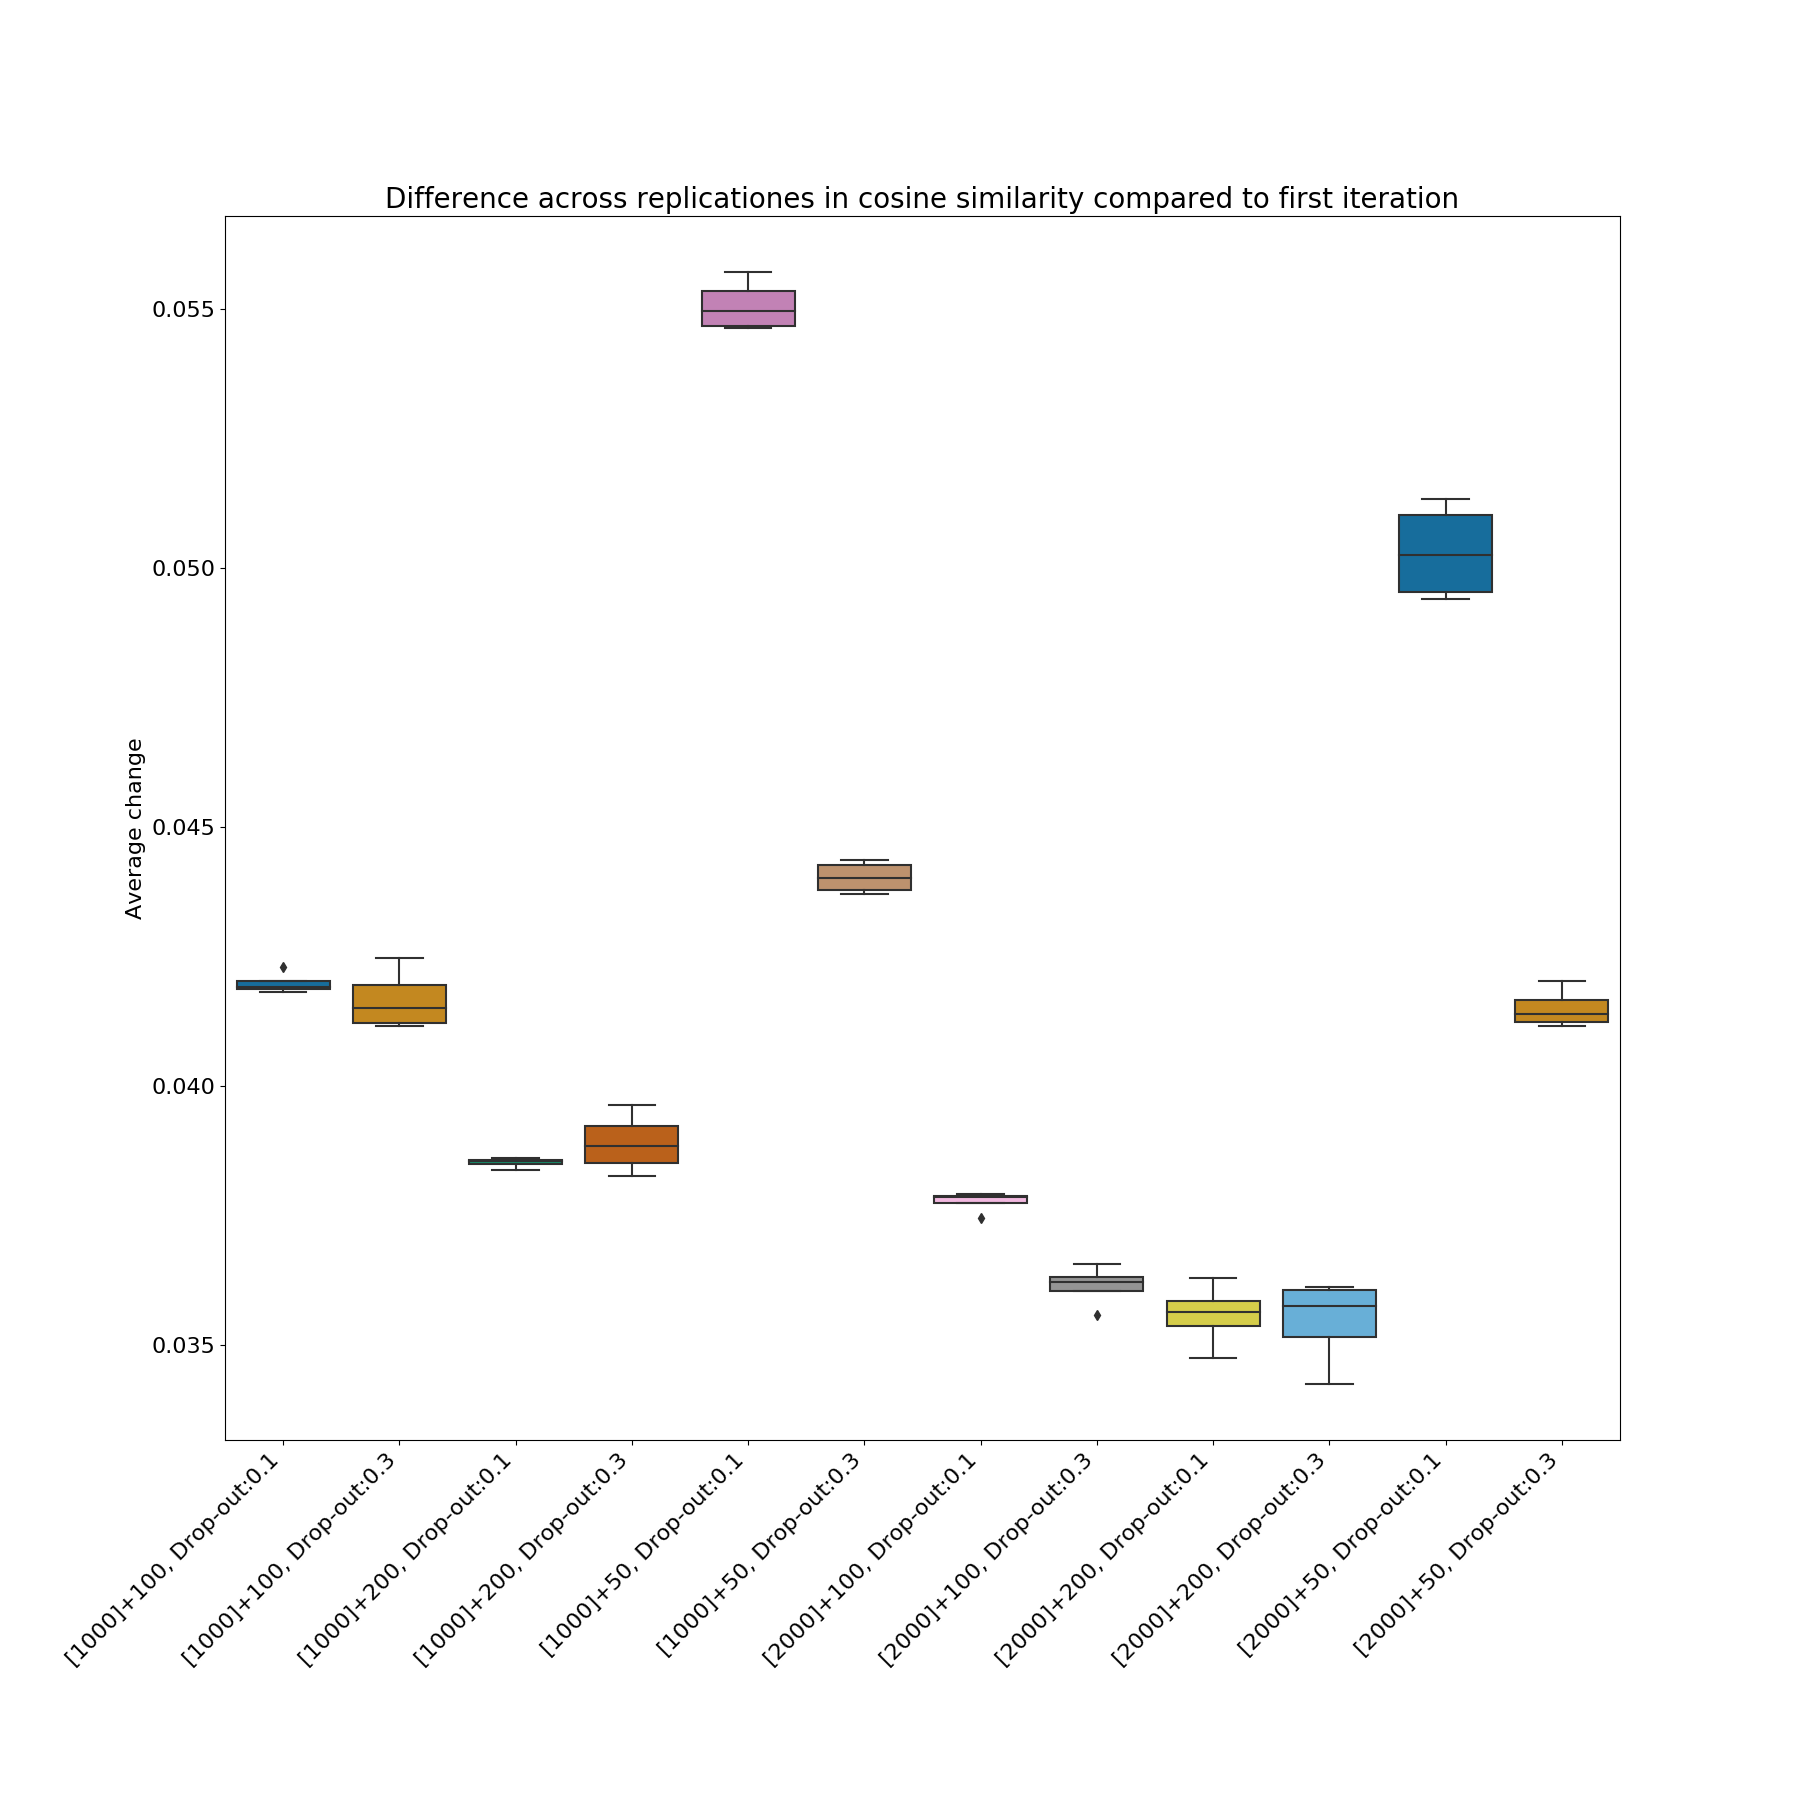

From here on the optimal setting for further analysis can be selected. This includes the framework used in MOVE for identifying drug and multi-omics assosiations as descriped in the notebook <i>identify_drug_assosiation.ipynb</i>, compare the latent space integration to other methods (PCA) using the notebook <i>latent_space_analysis.ipynb</i> or for other types of analysis such as clustering of the latent space (not included here). 